In [45]:
# Import Dependencies
%matplotlib inline
# Start Python Imports
import math, time, random, datetime
 
# Data Manipulation
import numpy as np
import pandas as pd
 
# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
 
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
 
# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
 
# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
 
# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')

In [46]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
gender_submission = pd.read_csv('input/gender_submission.csv')
train.head(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [47]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [48]:
def bar_chart(feature, train=train):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(5,5), mark_right = True)

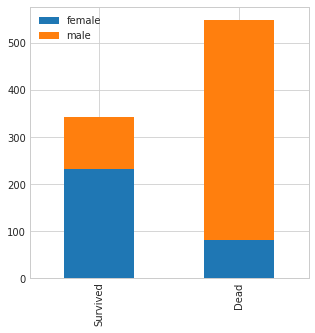

In [49]:
bar_chart('Sex')
# Большинство выживших, женщины

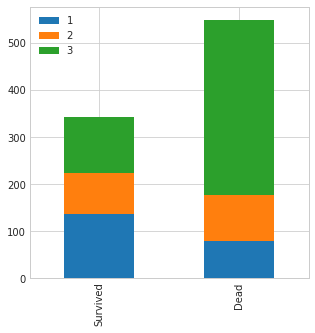

In [50]:
bar_chart('Pclass')
# Выживаемость, 1 класс - высокая, 2 класс - 50/50, 3 класс - низкая

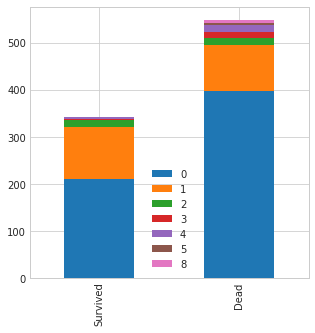

In [51]:
bar_chart('SibSp')
# Отсутствие супруга/братьев - скорее не выживет
# Наличие 1-2 родственников данного типа - 50/50
# Более 2 - высокая вероятность выжить

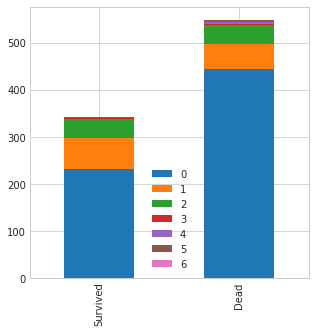

In [52]:
bar_chart('Parch')
# Отсутствие родителей/детей - скорее умерет
# 1-2 - 50/50
# Более 2 - скорее выживет

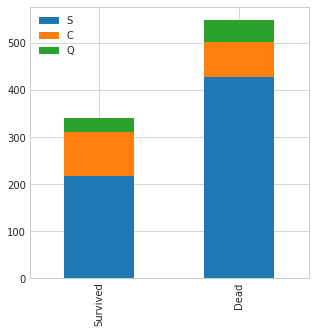

In [53]:
bar_chart('Embarked')
# Порт посадки
# Southhampton, Queenstown - скорее умрет
# Cherbourg - скорее выживет

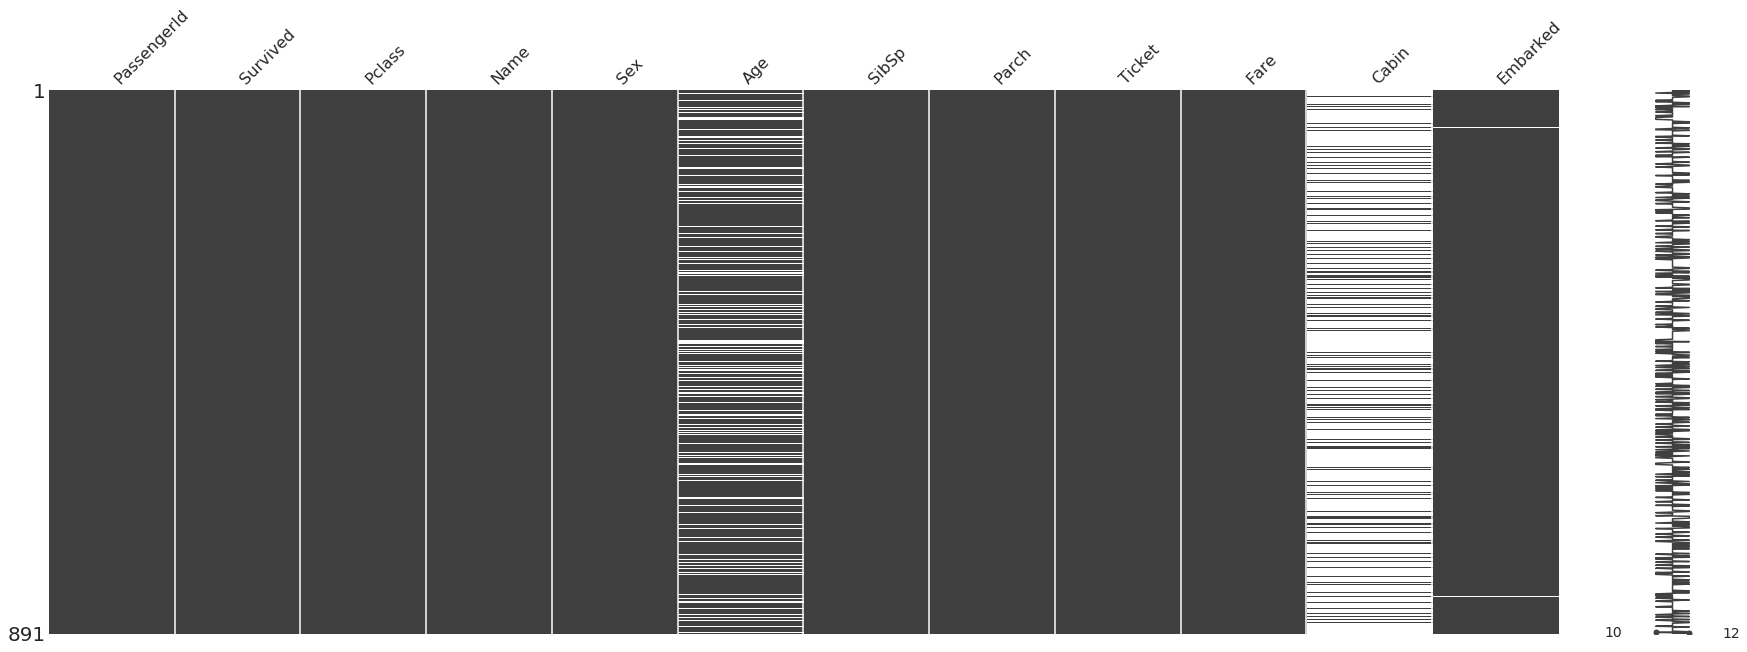

In [629]:
missingno.matrix(train, figsize=(30, 10));
# Очень много пропусков в Cabin, скорее всего ненужная колонка
# Много пропусков в Age, нужно будет заполнить
# Пара пропусков в Embarked, либо удалить строки либо заполнить


In [54]:
# Создадим два новых dataframes
df_bin = pd.DataFrame() 
df_con = pd.DataFrame()

0    549
1    342
Name: Survived, dtype: int64


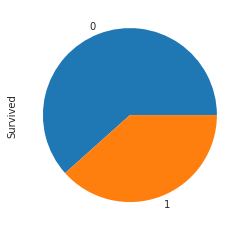

In [55]:
train['Survived'].value_counts().plot.pie()
print(train['Survived'].value_counts())
# Общее соотношение выживших/погибших

In [56]:
df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']
# Добавим эту колонку в новые dataframes

(<matplotlib.axes._subplots.AxesSubplot at 0x10e622cf8>,
 1    136
 3    119
 2     87
 Name: Pclass, dtype: int64)

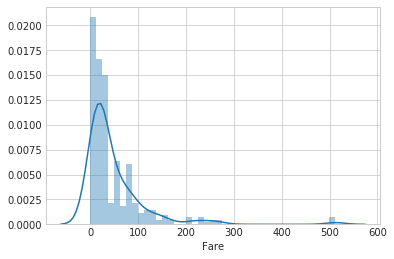

In [57]:
sns.distplot(train[train.Survived == 1].Fare, kde=True),\
train[train.Survived == 1].Pclass.value_counts()
# Распределение классов кают

In [58]:
df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

male      577
female    314
Name: Sex, dtype: int64


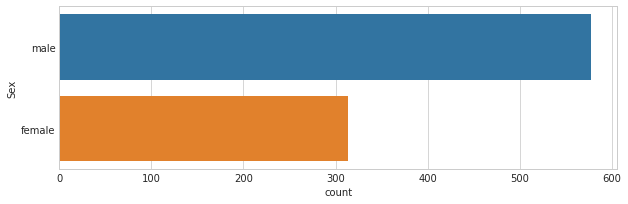

In [59]:
plt.figure(figsize=(10,3))
sns.countplot(y='Sex', data=train)
print(train['Sex'].value_counts())
# Гендерное соотношение

In [60]:
train.Sex.head()
# т.к. всего два возможных значения для этого поля, переведем их бинарное

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [62]:
df_bin['Sex'] = train['Sex']
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)
df_con['Sex'] = train['Sex']
df_bin.head()
# 1 - женщина, 0 - мужчина

,Survived,Pclass,Sex
0,0,3,0
1,1,1,1
2,1,3,1
3,1,1,1
4,0,3,0


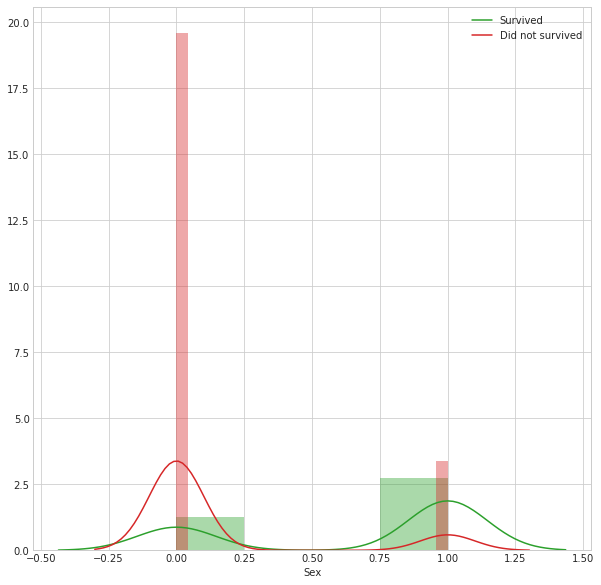

In [63]:
plt.figure(figsize=(10,10))
sns.distplot(df_bin.loc[df_bin['Survived'] == 1]['Sex'], kde_kws={'label': 'Survived'}, color="tab:green")
sns.distplot(df_bin.loc[df_bin['Survived'] == 0]['Sex'], kde_kws={'label': 'Did not survived'}, color="tab:red")
# Соотношение выживших/погибших среди мужчин и женщин

In [64]:
train.Age.isna().sum()
# Заполнить пустые значения

177

In [65]:
df_bin['SibSp'] = train['SibSp']
df_con['SibSp'] = train['SibSp']

In [66]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"}, color="tab:green");
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"}, color="tab:red");

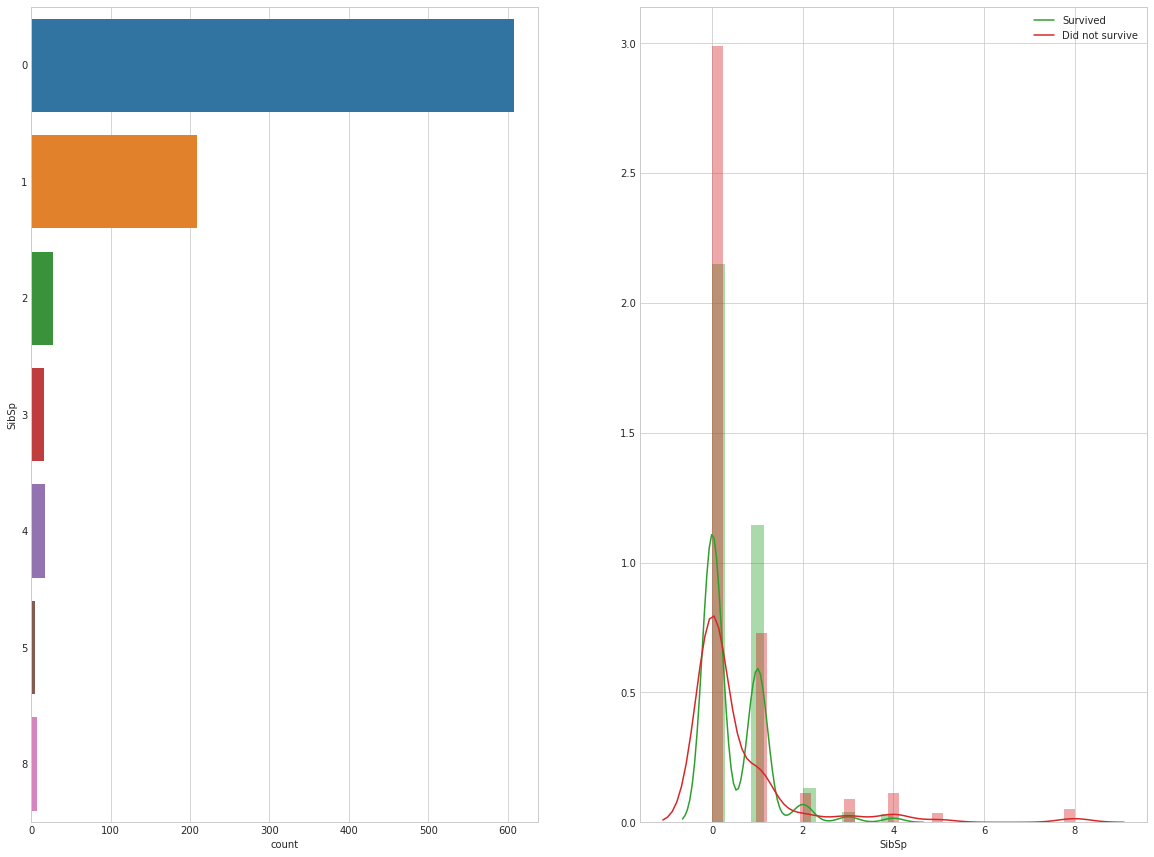

In [67]:
plot_count_dist(data=train, bin_df=df_bin, label_column='Survived', target_column='SibSp', figsize=(20,15))

In [68]:
df_bin['Parch'] = train['Parch']
df_con['Parch'] = train['Parch']

In [70]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch
0,0,3,0,1,0
1,1,1,1,1,0
2,1,3,1,0,0
3,1,1,1,1,0
4,0,3,0,0,0


In [ ]:
# Добавить поле Title
# Пропущенные значения Age можно заполнить медианами для каждого Title
# А затем перевести их в значения типа child - 0, young - 1, adult - 2, mid_age - 3, senior - 4

In [71]:
train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()
# Титулы, содержащиеся в именах
# Основных 3, оставшиеся можно поместить в 4 группу

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Sir           1
Capt          1
Jonkheer      1
Lady          1
Ms            1
Countess      1
Mme           1
Don           1
Name: Name, dtype: int64

In [72]:
df_con['Name'] = train['Name']
df_con.head(10)
train_test_data = [df_con]
for title in train_test_data:
    title['Title'] = title['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
# Записываем в df_con строковой титул

In [74]:
df_con.head(10)

,Survived,Pclass,Sex,SibSp,Parch,Name,Title
0,0,3,male,1,0,"Braund, Mr. Owen Harris",Mr
1,1,1,female,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,1,3,female,0,0,"Heikkinen, Miss. Laina",Miss
3,1,1,female,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,0,3,male,0,0,"Allen, Mr. William Henry",Mr
5,0,3,male,0,0,"Moran, Mr. James",Mr
6,0,1,male,0,0,"McCarthy, Mr. Timothy J",Mr
7,0,3,male,3,1,"Palsson, Master. Gosta Leonard",Master
8,1,3,female,0,2,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs
9,1,2,female,1,0,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs


In [75]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3,"Countess": 3,
                 "Ms": 3, "Lady": 3, "Jonkheer": 3, "Don": 3, "Dona" : 3, "Mme": 3,"Capt": 3,"Sir": 3}
for bin_title in [df_con]:
    df_bin['Title'] = bin_title['Title'].map(title_mapping)
df_bin.head(15)
# Делаем мапинг, чтобы в df_bin в Title записались уже числовые значения

,Survived,Pclass,Sex,SibSp,Parch,Title
0,0,3,0,1,0,0
1,1,1,1,1,0,2
2,1,3,1,0,0,1
3,1,1,1,1,0,2
4,0,3,0,0,0,0
5,0,3,0,0,0,0
6,0,1,0,0,0,0
7,0,3,0,3,1,3
8,1,3,1,0,2,2
9,1,2,1,1,0,2


In [81]:
df_bin['Age'] = train['Age']
df_con['Age'] = train['Age']

In [83]:
df_bin['Age'].fillna(df_bin.groupby('Title')['Age'].transform('median'), inplace=True)
df_con['Age'].fillna(df_con.groupby('Title')['Age'].transform('median'), inplace=True)
# Заполняем пустоты медианами для соответствующих титулов

In [86]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Title,Age
0,0,3,0,1,0,0,1.0
1,1,1,1,1,0,2,3.0
2,1,3,1,0,0,1,2.0
3,1,1,1,1,0,2,2.0
4,0,3,0,0,0,0,2.0


In [85]:
# Средняя продолжительность жизни в Великобритании, начала 20 века (так говорит гугл)
# Мужчины - 51 год, женщины - 55 лет
# На основании этого разобьем возраст на группы
for bin_age in [df_bin]:
    bin_age.loc[bin_age['Age'] <= 15, 'Age'] = 0, # Дети
    bin_age.loc[(bin_age['Age'] > 15) & (bin_age['Age'] <= 25), 'Age'] = 1, # Молодые
    bin_age.loc[(bin_age['Age'] > 25) & (bin_age['Age'] <= 35), 'Age'] = 2, # Взрослые
    bin_age.loc[(bin_age['Age'] > 35) & (bin_age['Age'] <= 48), 'Age'] = 3, # Средний возраст
    bin_age.loc[(bin_age['Age'] > 48), 'Age'] = 4 # Пожилые

2.0    332
1.0    254
3.0    137
0.0     88
4.0     80
Name: Age, dtype: int64


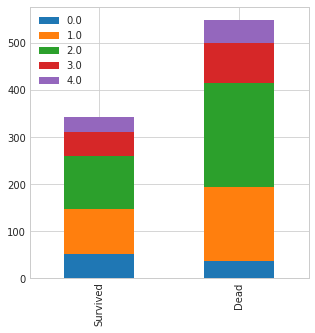

In [88]:
bar_chart('Age', train=df_bin)
print(df_bin.Age.value_counts())
# Как видно из графика только у детей(age<=15) выживаемость привысила смертность

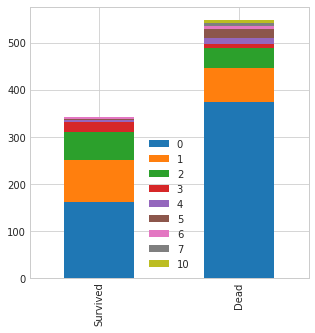

In [89]:
# Общее количество родственников на борту
df_bin['family_size'] = df_bin['SibSp'] + df_bin['Parch']

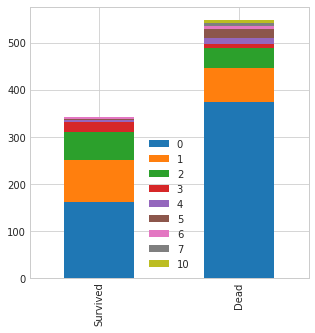

In [90]:
# Как видно из графика выживаемость привызила смертность у людей с кол0ом родственников от 1 до 3
bar_chart('family_size', train=df_bin)

In [102]:
df_bin['needable_family_size'] = np.where(np.logical_and(df_bin['family_size']>0, df_bin['family_size']<=3), 
                                      1, 0)
# Исходя из предыдущего вывода добавим бинарную фичу

In [91]:
print(train.Embarked.isna().sum())
train.Embarked.value_counts()
# Всего два пропуска в поле Embarked

2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [92]:
# Заполним их S, т.к. большинство село там
df_con['Embarked'] = train['Embarked']
for embarked_con in [df_con]:
    embarked_con['Embarked'] = embarked_con['Embarked'].fillna('S')

In [93]:
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
df_bin['Embarked'] = df_con['Embarked']
for embarked_bin in [df_bin]:
    embarked_bin['Embarked'] = embarked_bin['Embarked'].map(embarked_map)
# Заполним числовыми значениями Embarked в df_bin

In [95]:
# Приведем Age в int
df_bin.Age = df_bin.Age.astype(np.int64)

In [108]:
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Title,Age,family_size,Embarked,Fare,needable_family_size
0,0,3,0,1,0,0,1,1,0,0,1
1,1,1,1,1,0,2,3,1,1,2,1
2,1,3,1,0,0,1,2,0,0,0,0
3,1,1,1,1,0,2,2,1,0,2,1
4,0,3,0,0,0,0,2,0,0,0,0


In [100]:
df_bin['Fare'] = train['Fare']

In [105]:
df_bin.Fare.isna().sum()

0

In [106]:
# Приведем стоимость билетов к 4 группам(возможно стоит поэксперементировать с разделением)
for dataset in [df_bin]:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3
df_bin.head()

,Survived,Pclass,Sex,SibSp,Parch,Title,Age,family_size,Embarked,Fare,needable_family_size
0,0,3,0,1,0,0,1,1,0,0.0,1
1,1,1,1,1,0,2,3,1,1,2.0,1
2,1,3,1,0,0,1,2,0,0,0.0,0
3,1,1,1,1,0,2,2,1,0,2.0,1
4,0,3,0,0,0,0,2,0,0,0.0,0


In [107]:
df_bin.Fare = df_bin.Fare.astype(np.int64)

In [109]:
# Разделим dataframe на основные данные и фичу, которую предсказываем
x_train = df_bin.drop('Survived', axis=1) # data
y_train = df_bin.Survived # labels

x_train.head()

,Pclass,Sex,SibSp,Parch,Title,Age,family_size,Embarked,Fare,needable_family_size
0,3,0,1,0,0,1,1,0,0,1
1,1,1,1,0,2,3,1,1,2,1
2,3,1,0,0,1,2,0,0,0,0
3,1,1,1,0,2,2,1,0,2,1
4,3,0,0,0,0,2,0,0,0,0


In [111]:
# Универсальная функция для тестирования различных подходов
@timer
def fit_ml_algo(algo, df_bin, feature=y_train, cv=7):
    
    # One Pass
    model = algo.fit(df_bin, feature)
    acc = round(model.score(df_bin, feature) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  df_bin, 
                                                  feature, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(feature, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

In [110]:
# Функция счетчик
from functools import wraps

def timer(func):
    @wraps(func)
    def _time_it(*args, **kwargs):
        start = int(round(time.time() * 1000))
        try:
            return func(*args, **kwargs)
        finally:
            end_ = int(round(time.time() * 1000)) - start
            print(f"Total execution time: {end_ if end_ > 0 else 0} ms")
    return _time_it

In [112]:
# Логистическая регрессия
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), x_train)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)

Total execution time: 1567 ms
Accuracy: 82.04
Accuracy CV 10-Fold: 81.59


In [113]:
# Метод ближайших соседей
train_pred_log, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), x_train)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)

Total execution time: 127 ms
Accuracy: 84.85
Accuracy CV 10-Fold: 80.92


In [114]:
# Наивный Байес
train_pred_log, acc_gnb, acc_cv_gnb = fit_ml_algo(GaussianNB(), x_train)
print("Accuracy: %s" % acc_gnb)
print("Accuracy CV 10-Fold: %s" % acc_cv_gnb)

Total execution time: 39 ms
Accuracy: 79.57
Accuracy CV 10-Fold: 79.46


In [115]:
# Метод опорных векторов
train_pred_log, acc_lcvc, acc_cv_lcvc = fit_ml_algo(LinearSVC(), x_train)
print("Accuracy: %s" % acc_lcvc)
print("Accuracy CV 10-Fold: %s" % acc_cv_lcvc)

Total execution time: 148 ms
Accuracy: 82.49
Accuracy CV 10-Fold: 82.27


In [116]:
# Стохастический градиентный спуск
train_pred_log, acc_sgdc, acc_cv_sdgc = fit_ml_algo(SGDClassifier(), x_train)
print("Accuracy: %s" % acc_sgdc)
print("Accuracy CV 10-Fold: %s" % acc_cv_sdgc)

Total execution time: 60 ms
Accuracy: 79.8
Accuracy CV 10-Fold: 75.65


In [117]:
# Дерево принятия решений
train_pred_log, acc_dtc, acc_cv_dtc = fit_ml_algo(DecisionTreeClassifier(), x_train)
print("Accuracy: %s" % acc_dtc)
print("Accuracy CV 10-Fold: %s" % acc_cv_dtc)

Total execution time: 64 ms
Accuracy: 89.23
Accuracy CV 10-Fold: 79.69


In [118]:
# Градиентный бустинг
train_pred_log, acc_gbc, acc_cv_gbc = fit_ml_algo(GradientBoostingClassifier(), x_train)
print("Accuracy: %s" % acc_gbc)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbc)

Total execution time: 396 ms
Accuracy: 85.97
Accuracy CV 10-Fold: 81.93


In [119]:
# Random Forest
train_pred_log, acc_rfc, acc_cv_rfc = fit_ml_algo(RandomForestClassifier(), x_train)
print("Accuracy: %s" % acc_rfc)
print("Accuracy CV 10-Fold: %s" % acc_cv_rfc)

Total execution time: 708 ms
Accuracy: 89.23
Accuracy CV 10-Fold: 80.25


In [753]:
# Итоговая таблица accuracy
accuracy_models = pd.DataFrame({
    'Models': ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'LinearSVC', 'SGDClassifier', 
               'DecisionTreeClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier'],
    'Accuracy': [acc_log, acc_knn, acc_gnb, acc_lcvc, acc_sgdc, acc_dtc, acc_gbc, acc_rfc]
})
accuracy_models.sort_values('Accuracy', ascending=False)

,Models,Accuracy
5,DecisionTreeClassifier,89.23
7,RandomForestClassifier,89.23
6,GradientBoostingClassifier,85.75
1,KNeighborsClassifier,84.29
3,LinearSVC,82.49
0,LogisticRegression,82.04
2,GaussianNB,79.91
4,SGDClassifier,77.33


In [120]:
# Итоговая таблица cross-validation
cv_models = pd.DataFrame({
    'Models': ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'LinearSVC', 'SGDClassifier', 
               'DecisionTreeClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier'],
    'Cross_validation': [acc_cv_log, acc_cv_knn, acc_cv_gnb, acc_cv_lcvc, acc_cv_sdgc, acc_cv_dtc, 
                 acc_cv_gbc, acc_cv_rfc]
})
cv_models.sort_values('Cross_validation', ascending=False)

,Models,Cross_validation
3,LinearSVC,82.27
6,GradientBoostingClassifier,81.93
0,LogisticRegression,81.59
1,KNeighborsClassifier,80.92
7,RandomForestClassifier,80.25
5,DecisionTreeClassifier,79.69
2,GaussianNB,79.46
4,SGDClassifier,75.65


In [ ]:
# Когда тестил модели без needable_family_size и family_size результаты были примерно такие же
# на Cross_validation, но на первом месте был GradientBoostingClassifier

In [121]:
test = pd.read_csv('input/test.csv')
gender_submission = pd.read_csv('input/gender_submission.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


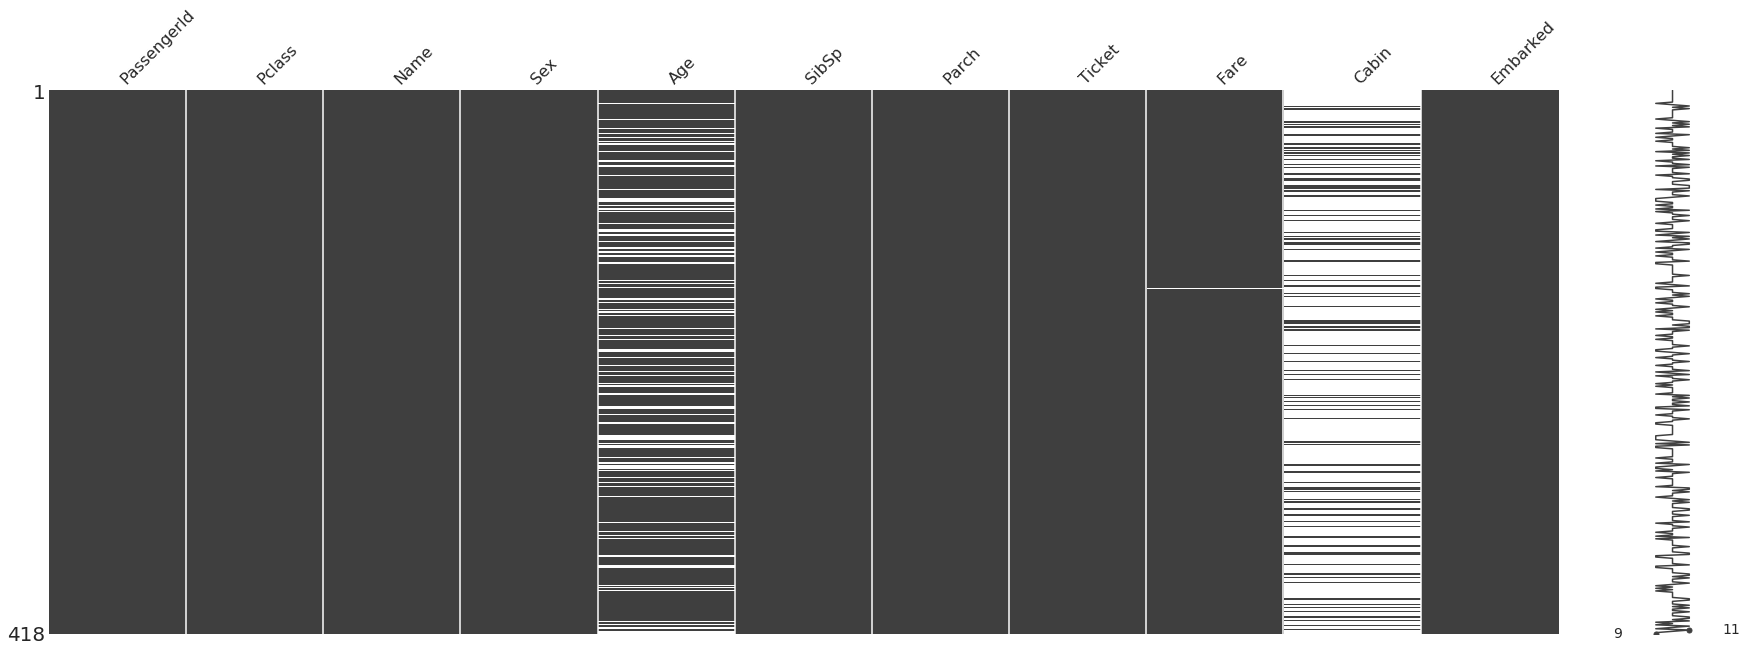

In [125]:
missingno.matrix(test, figsize=(30, 10))
test.info();
# Пропуски в Age и Fare, нужно будет заполнить. Cabin выкинуть.

In [720]:
for embarked_bin in [test]:
    embarked_bin['Embarked'] = embarked_bin['Embarked'].map(embarked_map)
test.head()
# Готовим данные по аналогии с train выборкой

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,2
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,0


In [126]:
for bin_age in [test]:
    bin_age.loc[bin_age['Age'] <= 15, 'Age'] = 0, # Дети
    bin_age.loc[(bin_age['Age'] > 15) & (bin_age['Age'] <= 25), 'Age'] = 1, # Молодые
    bin_age.loc[(bin_age['Age'] > 25) & (bin_age['Age'] <= 35), 'Age'] = 2, # Взрослые
    bin_age.loc[(bin_age['Age'] > 35) & (bin_age['Age'] <= 48), 'Age'] = 3, # Средний возраст
    bin_age.loc[(bin_age['Age'] > 48), 'Age'] = 4 # Пожилые
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,2.0,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,3.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,4.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,2.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,12.2875,NaN,S


In [128]:
for title in [test]:
    title['Title'] = title['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
for bin_title in [test]:
    bin_title['Title'] = bin_title['Title'].map(title_mapping)
test.head(16)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,2.0,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,3.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,4.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,2.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,12.2875,NaN,S,2
5,897,3,"Svensson, Mr. Johan Cervin",male,0.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,2.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,2.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1.0,0,0,2657,7.2292,NaN,C,2
9,901,3,"Davies, Mr. John Samuel",male,1.0,2,0,A/4 48871,24.1500,NaN,S,0


In [129]:
test['Age'].fillna(test.groupby('Title')['Age'].transform('median'), inplace=True)
test.head(16)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,2.0,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,3.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,4.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,2.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,12.2875,NaN,S,2
5,897,3,"Svensson, Mr. Johan Cervin",male,0.0,0,0,7538,9.2250,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,2.0,0,0,330972,7.6292,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,2.0,1,1,248738,29.0000,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1.0,0,0,2657,7.2292,NaN,C,2
9,901,3,"Davies, Mr. John Samuel",male,1.0,2,0,A/4 48871,24.1500,NaN,S,0


In [130]:
test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('median'), inplace=True)
for dataset in [test]:
    dataset.loc[ dataset['Fare'] <= 10, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 10) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3
test.Fare = test.Fare.astype(np.int64)
test.head(17)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,2.0,0,0,330911,0,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,3.0,1,0,363272,0,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,4.0,0,0,240276,0,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,2.0,0,0,315154,0,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,1.0,1,1,3101298,1,NaN,S,2
5,897,3,"Svensson, Mr. Johan Cervin",male,0.0,0,0,7538,0,NaN,S,0
6,898,3,"Connolly, Miss. Kate",female,2.0,0,0,330972,0,NaN,Q,1
7,899,2,"Caldwell, Mr. Albert Francis",male,2.0,1,1,248738,1,NaN,S,0
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,1.0,0,0,2657,0,NaN,C,2
9,901,3,"Davies, Mr. John Samuel",male,1.0,2,0,A/4 48871,1,NaN,S,0


In [131]:
test['Sex'] = np.where(test['Sex'] == 'female', 1, 0)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",0,2.0,0,0,330911,0,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,3.0,1,0,363272,0,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",0,4.0,0,0,240276,0,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",0,2.0,0,0,315154,0,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1.0,1,1,3101298,1,NaN,S,2


In [132]:
test['family_size'] = test['SibSp'] + test['Parch']
test['needable_family_size'] = np.where(np.logical_and(test['family_size']>0, test['family_size']<=3), 
                                      1, 0)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,family_size,needable_family_size
0,892,3,"Kelly, Mr. James",0,2.0,0,0,330911,0,NaN,Q,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,3.0,1,0,363272,0,NaN,S,2,1,1
2,894,2,"Myles, Mr. Thomas Francis",0,4.0,0,0,240276,0,NaN,Q,0,0,0
3,895,3,"Wirz, Mr. Albert",0,2.0,0,0,315154,0,NaN,S,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1.0,1,1,3101298,1,NaN,S,2,2,1


In [137]:
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
for embarked_bin in [test]:
    embarked_bin['Embarked'] = embarked_bin['Embarked'].map(embarked_map)

In [ ]:
test.Age = test.Age.astype(np.int64)

In [138]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,family_size,needable_family_size
0,892,3,"Kelly, Mr. James",0,2.0,0,0,330911,0,NaN,2,0,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,3.0,1,0,363272,0,NaN,0,2,1,1
2,894,2,"Myles, Mr. Thomas Francis",0,4.0,0,0,240276,0,NaN,2,0,0,0
3,895,3,"Wirz, Mr. Albert",0,2.0,0,0,315154,0,NaN,0,0,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1.0,1,1,3101298,1,NaN,0,2,2,1


In [139]:
# Фичи, с которыми работали на train выборке
wanted_test_columns = x_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Title', 'Age', 'family_size',
       'Embarked', 'Fare', 'needable_family_size'],
      dtype='object')

In [371]:
train_pred_, gradient_boost, gradient_boost_cv = fit_ml_algo(GradientBoostingClassifier(), 
                                                             test[wanted_test_columns], 
                                                             feature=gender_submission.Survived)
print("Accuracy: %s" % gradient_boost)
print("Accuracy CV 10-Fold: %s" % gradient_boost_cv)
#test[wanted_test_columns].isna().sum()

Total execution time: 243 ms
Accuracy: 100.0
Accuracy CV 10-Fold: 100.0


In [140]:
clf = LinearSVC()
clf.fit(x_train, y_train)
prediction = clf.predict(test[wanted_test_columns])
# Берем лучшую модель

In [141]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": prediction
    })

submission.to_csv('submission_linear_scv_1.csv', index=False)

In [ ]:
# После сабмита на kaggle получили результат 0.78468
# Лучший результат с GradientBoosting был 0.79904
# TODO: Подумать на счет версионности в юпитере

In [146]:
cat_features = np.where(x_train.dtypes != np.float)[0]

In [147]:
# CatBoost
train_pool = Pool(x_train, y_train, cat_features)

catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

catboost_model.fit(train_pool,
                   plot=True)


acc_catboost = round(catboost_model.score(x_train, y_train) * 100, 2)

Learning rate set to 0.009807


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6894075	total: 7.27ms	remaining: 7.26s
1:	learn: 0.6839388	total: 39ms	remaining: 19.5s
2:	learn: 0.6786025	total: 45.2ms	remaining: 15s
3:	learn: 0.6732492	total: 52ms	remaining: 12.9s
4:	learn: 0.6672988	total: 60.8ms	remaining: 12.1s
5:	learn: 0.6620310	total: 67.1ms	remaining: 11.1s
6:	learn: 0.6569245	total: 71.3ms	remaining: 10.1s
7:	learn: 0.6517245	total: 77ms	remaining: 9.54s
8:	learn: 0.6476670	total: 81.1ms	remaining: 8.93s
9:	learn: 0.6425453	total: 87.3ms	remaining: 8.65s
10:	learn: 0.6368177	total: 94.9ms	remaining: 8.53s
11:	learn: 0.6326151	total: 100ms	remaining: 8.26s
12:	learn: 0.6281862	total: 106ms	remaining: 8.08s
13:	learn: 0.6236470	total: 113ms	remaining: 7.93s
14:	learn: 0.6195807	total: 118ms	remaining: 7.77s
15:	learn: 0.6146076	total: 127ms	remaining: 7.78s
16:	learn: 0.6101522	total: 134ms	remaining: 7.74s
17:	learn: 0.6059747	total: 140ms	remaining: 7.63s
18:	learn: 0.6016503	total: 147ms	remaining: 7.58s
19:	learn: 0.5974574	total: 154ms	rema

175:	learn: 0.3966959	total: 1.2s	remaining: 5.61s
176:	learn: 0.3965192	total: 1.21s	remaining: 5.61s
177:	learn: 0.3961165	total: 1.22s	remaining: 5.62s
178:	learn: 0.3956544	total: 1.22s	remaining: 5.62s
179:	learn: 0.3952004	total: 1.23s	remaining: 5.62s
180:	learn: 0.3947140	total: 1.24s	remaining: 5.61s
181:	learn: 0.3944464	total: 1.25s	remaining: 5.61s
182:	learn: 0.3940691	total: 1.25s	remaining: 5.6s
183:	learn: 0.3940068	total: 1.26s	remaining: 5.58s
184:	learn: 0.3939347	total: 1.26s	remaining: 5.56s
185:	learn: 0.3933981	total: 1.27s	remaining: 5.55s
186:	learn: 0.3931980	total: 1.28s	remaining: 5.55s
187:	learn: 0.3929008	total: 1.28s	remaining: 5.55s
188:	learn: 0.3925126	total: 1.29s	remaining: 5.54s
189:	learn: 0.3924406	total: 1.29s	remaining: 5.52s
190:	learn: 0.3919906	total: 1.3s	remaining: 5.52s
191:	learn: 0.3915984	total: 1.31s	remaining: 5.52s
192:	learn: 0.3913406	total: 1.32s	remaining: 5.52s
193:	learn: 0.3910693	total: 1.33s	remaining: 5.52s
194:	learn: 0.3

357:	learn: 0.3600252	total: 2.39s	remaining: 4.28s
358:	learn: 0.3598933	total: 2.39s	remaining: 4.27s
359:	learn: 0.3598642	total: 2.4s	remaining: 4.26s
360:	learn: 0.3596598	total: 2.4s	remaining: 4.26s
361:	learn: 0.3594206	total: 2.41s	remaining: 4.25s
362:	learn: 0.3593109	total: 2.42s	remaining: 4.24s
363:	learn: 0.3592961	total: 2.42s	remaining: 4.23s
364:	learn: 0.3592820	total: 2.42s	remaining: 4.22s
365:	learn: 0.3592263	total: 2.43s	remaining: 4.21s
366:	learn: 0.3591680	total: 2.43s	remaining: 4.2s
367:	learn: 0.3589384	total: 2.44s	remaining: 4.19s
368:	learn: 0.3588232	total: 2.45s	remaining: 4.18s
369:	learn: 0.3586118	total: 2.45s	remaining: 4.18s
370:	learn: 0.3583321	total: 2.46s	remaining: 4.17s
371:	learn: 0.3582002	total: 2.47s	remaining: 4.16s
372:	learn: 0.3580753	total: 2.47s	remaining: 4.16s
373:	learn: 0.3580183	total: 2.48s	remaining: 4.14s
374:	learn: 0.3577093	total: 2.48s	remaining: 4.14s
375:	learn: 0.3575838	total: 2.49s	remaining: 4.13s
376:	learn: 0.3

546:	learn: 0.3364196	total: 3.58s	remaining: 2.97s
547:	learn: 0.3362247	total: 3.59s	remaining: 2.96s
548:	learn: 0.3360553	total: 3.6s	remaining: 2.96s
549:	learn: 0.3357962	total: 3.6s	remaining: 2.95s
550:	learn: 0.3356612	total: 3.61s	remaining: 2.94s
551:	learn: 0.3355540	total: 3.62s	remaining: 2.94s
552:	learn: 0.3354936	total: 3.62s	remaining: 2.93s
553:	learn: 0.3353731	total: 3.63s	remaining: 2.92s
554:	learn: 0.3352877	total: 3.64s	remaining: 2.92s
555:	learn: 0.3352784	total: 3.64s	remaining: 2.91s
556:	learn: 0.3351998	total: 3.65s	remaining: 2.9s
557:	learn: 0.3350715	total: 3.65s	remaining: 2.89s
558:	learn: 0.3350508	total: 3.65s	remaining: 2.88s
559:	learn: 0.3349342	total: 3.66s	remaining: 2.88s
560:	learn: 0.3349093	total: 3.67s	remaining: 2.87s
561:	learn: 0.3348534	total: 3.67s	remaining: 2.86s
562:	learn: 0.3346864	total: 3.68s	remaining: 2.85s
563:	learn: 0.3346276	total: 3.68s	remaining: 2.85s
564:	learn: 0.3345284	total: 3.69s	remaining: 2.84s
565:	learn: 0.3

711:	learn: 0.3197376	total: 4.58s	remaining: 1.85s
712:	learn: 0.3197367	total: 4.58s	remaining: 1.84s
713:	learn: 0.3195695	total: 4.59s	remaining: 1.84s
714:	learn: 0.3195643	total: 4.59s	remaining: 1.83s
715:	learn: 0.3194835	total: 4.6s	remaining: 1.82s
716:	learn: 0.3193416	total: 4.6s	remaining: 1.82s
717:	learn: 0.3192724	total: 4.61s	remaining: 1.81s
718:	learn: 0.3190861	total: 4.62s	remaining: 1.8s
719:	learn: 0.3189976	total: 4.62s	remaining: 1.8s
720:	learn: 0.3187829	total: 4.63s	remaining: 1.79s
721:	learn: 0.3186928	total: 4.63s	remaining: 1.78s
722:	learn: 0.3185603	total: 4.64s	remaining: 1.78s
723:	learn: 0.3184149	total: 4.65s	remaining: 1.77s
724:	learn: 0.3181391	total: 4.65s	remaining: 1.76s
725:	learn: 0.3180044	total: 4.66s	remaining: 1.76s
726:	learn: 0.3178793	total: 4.66s	remaining: 1.75s
727:	learn: 0.3178262	total: 4.67s	remaining: 1.75s
728:	learn: 0.3178063	total: 4.68s	remaining: 1.74s
729:	learn: 0.3177270	total: 4.68s	remaining: 1.73s
730:	learn: 0.31

899:	learn: 0.3014252	total: 5.78s	remaining: 642ms
900:	learn: 0.3013320	total: 5.79s	remaining: 636ms
901:	learn: 0.3011739	total: 5.79s	remaining: 630ms
902:	learn: 0.3010999	total: 5.8s	remaining: 623ms
903:	learn: 0.3009959	total: 5.81s	remaining: 617ms
904:	learn: 0.3007834	total: 5.81s	remaining: 610ms
905:	learn: 0.3006957	total: 5.82s	remaining: 604ms
906:	learn: 0.3006543	total: 5.83s	remaining: 598ms
907:	learn: 0.3004753	total: 5.83s	remaining: 591ms
908:	learn: 0.3004158	total: 5.84s	remaining: 585ms
909:	learn: 0.3004001	total: 5.84s	remaining: 578ms
910:	learn: 0.3003783	total: 5.85s	remaining: 572ms
911:	learn: 0.3002977	total: 5.86s	remaining: 565ms
912:	learn: 0.3001286	total: 5.86s	remaining: 559ms
913:	learn: 0.3001128	total: 5.87s	remaining: 552ms
914:	learn: 0.2999562	total: 5.88s	remaining: 546ms
915:	learn: 0.2998237	total: 5.88s	remaining: 539ms
916:	learn: 0.2996613	total: 5.89s	remaining: 533ms
917:	learn: 0.2995590	total: 5.89s	remaining: 527ms
918:	learn: 0

In [148]:
start_time = time.time()

cv_params = catboost_model.get_params()

cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

catboost_time = (time.time() - start_time)

acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6763581	test: 0.6765737	best: 0.6765737 (0)	total: 121ms	remaining: 2m 1s
1:	learn: 0.6601361	test: 0.6609721	best: 0.6609721 (1)	total: 201ms	remaining: 1m 40s
2:	learn: 0.6436839	test: 0.6451973	best: 0.6451973 (2)	total: 304ms	remaining: 1m 41s
3:	learn: 0.6298740	test: 0.6318300	best: 0.6318300 (3)	total: 384ms	remaining: 1m 35s
4:	learn: 0.6160928	test: 0.6181869	best: 0.6181869 (4)	total: 479ms	remaining: 1m 35s
5:	learn: 0.6025836	test: 0.6055925	best: 0.6055925 (5)	total: 574ms	remaining: 1m 35s
6:	learn: 0.5905946	test: 0.5941095	best: 0.5941095 (6)	total: 654ms	remaining: 1m 32s
7:	learn: 0.5791363	test: 0.5835230	best: 0.5835230 (7)	total: 736ms	remaining: 1m 31s
8:	learn: 0.5679762	test: 0.5732990	best: 0.5732990 (8)	total: 835ms	remaining: 1m 31s
9:	learn: 0.5584642	test: 0.5646729	best: 0.5646729 (9)	total: 920ms	remaining: 1m 31s
10:	learn: 0.5487256	test: 0.5556663	best: 0.5556663 (10)	total: 1.01s	remaining: 1m 30s
11:	learn: 0.5403233	test: 0.5475374	best:

95:	learn: 0.3688844	test: 0.4212167	best: 0.4211388 (93)	total: 8.31s	remaining: 1m 18s
96:	learn: 0.3686604	test: 0.4212227	best: 0.4211388 (93)	total: 8.38s	remaining: 1m 18s
97:	learn: 0.3682661	test: 0.4208720	best: 0.4208720 (97)	total: 8.46s	remaining: 1m 17s
98:	learn: 0.3676810	test: 0.4206073	best: 0.4206073 (98)	total: 8.55s	remaining: 1m 17s
99:	learn: 0.3672679	test: 0.4203234	best: 0.4203234 (99)	total: 8.64s	remaining: 1m 17s
100:	learn: 0.3666752	test: 0.4199056	best: 0.4199056 (100)	total: 8.72s	remaining: 1m 17s
101:	learn: 0.3662014	test: 0.4198684	best: 0.4198684 (101)	total: 8.79s	remaining: 1m 17s
102:	learn: 0.3656859	test: 0.4197887	best: 0.4197887 (102)	total: 8.87s	remaining: 1m 17s
103:	learn: 0.3650480	test: 0.4194989	best: 0.4194989 (103)	total: 8.96s	remaining: 1m 17s
104:	learn: 0.3644341	test: 0.4192774	best: 0.4192774 (104)	total: 9.04s	remaining: 1m 17s
105:	learn: 0.3640875	test: 0.4192259	best: 0.4192259 (105)	total: 9.17s	remaining: 1m 17s
106:	lear

187:	learn: 0.3316042	test: 0.4158733	best: 0.4153238 (171)	total: 17.6s	remaining: 1m 15s
188:	learn: 0.3313652	test: 0.4158097	best: 0.4153238 (171)	total: 17.7s	remaining: 1m 15s
189:	learn: 0.3310176	test: 0.4157401	best: 0.4153238 (171)	total: 17.8s	remaining: 1m 15s
190:	learn: 0.3307505	test: 0.4157381	best: 0.4153238 (171)	total: 17.9s	remaining: 1m 15s
191:	learn: 0.3303613	test: 0.4157946	best: 0.4153238 (171)	total: 18s	remaining: 1m 15s
192:	learn: 0.3300910	test: 0.4157872	best: 0.4153238 (171)	total: 18.1s	remaining: 1m 15s
193:	learn: 0.3297477	test: 0.4157173	best: 0.4153238 (171)	total: 18.2s	remaining: 1m 15s
194:	learn: 0.3293987	test: 0.4156695	best: 0.4153238 (171)	total: 18.3s	remaining: 1m 15s
195:	learn: 0.3292004	test: 0.4156595	best: 0.4153238 (171)	total: 18.4s	remaining: 1m 15s
196:	learn: 0.3290204	test: 0.4155202	best: 0.4153238 (171)	total: 18.6s	remaining: 1m 15s
197:	learn: 0.3288293	test: 0.4156471	best: 0.4153238 (171)	total: 18.7s	remaining: 1m 15s
1

279:	learn: 0.3057520	test: 0.4154356	best: 0.4151835 (209)	total: 27.5s	remaining: 1m 10s
280:	learn: 0.3054947	test: 0.4154651	best: 0.4151835 (209)	total: 27.7s	remaining: 1m 10s
281:	learn: 0.3051947	test: 0.4158411	best: 0.4151835 (209)	total: 27.8s	remaining: 1m 10s
282:	learn: 0.3050065	test: 0.4157960	best: 0.4151835 (209)	total: 27.9s	remaining: 1m 10s
283:	learn: 0.3047727	test: 0.4157175	best: 0.4151835 (209)	total: 27.9s	remaining: 1m 10s
284:	learn: 0.3044748	test: 0.4158689	best: 0.4151835 (209)	total: 28s	remaining: 1m 10s
285:	learn: 0.3042728	test: 0.4158917	best: 0.4151835 (209)	total: 28.1s	remaining: 1m 10s
286:	learn: 0.3040930	test: 0.4158657	best: 0.4151835 (209)	total: 28.2s	remaining: 1m 10s
287:	learn: 0.3038734	test: 0.4159095	best: 0.4151835 (209)	total: 28.3s	remaining: 1m 10s
288:	learn: 0.3035799	test: 0.4158491	best: 0.4151835 (209)	total: 28.4s	remaining: 1m 9s
289:	learn: 0.3034467	test: 0.4158665	best: 0.4151835 (209)	total: 28.5s	remaining: 1m 9s
290

373:	learn: 0.2837470	test: 0.4179409	best: 0.4151835 (209)	total: 36.9s	remaining: 1m 1s
374:	learn: 0.2834114	test: 0.4178572	best: 0.4151835 (209)	total: 37s	remaining: 1m 1s
375:	learn: 0.2831565	test: 0.4179768	best: 0.4151835 (209)	total: 37.1s	remaining: 1m 1s
376:	learn: 0.2829465	test: 0.4179994	best: 0.4151835 (209)	total: 37.2s	remaining: 1m 1s
377:	learn: 0.2827241	test: 0.4181094	best: 0.4151835 (209)	total: 37.3s	remaining: 1m 1s
378:	learn: 0.2824711	test: 0.4182794	best: 0.4151835 (209)	total: 37.4s	remaining: 1m 1s
379:	learn: 0.2822502	test: 0.4184251	best: 0.4151835 (209)	total: 37.4s	remaining: 1m 1s
380:	learn: 0.2820268	test: 0.4183942	best: 0.4151835 (209)	total: 37.5s	remaining: 1m
381:	learn: 0.2817727	test: 0.4185481	best: 0.4151835 (209)	total: 37.9s	remaining: 1m 1s
382:	learn: 0.2815765	test: 0.4184879	best: 0.4151835 (209)	total: 38s	remaining: 1m 1s
383:	learn: 0.2813506	test: 0.4184145	best: 0.4151835 (209)	total: 38.1s	remaining: 1m 1s
384:	learn: 0.281

466:	learn: 0.2641449	test: 0.4213430	best: 0.4151835 (209)	total: 46.7s	remaining: 53.3s
467:	learn: 0.2639520	test: 0.4214028	best: 0.4151835 (209)	total: 46.8s	remaining: 53.2s
468:	learn: 0.2637615	test: 0.4214920	best: 0.4151835 (209)	total: 47s	remaining: 53.2s
469:	learn: 0.2635635	test: 0.4214507	best: 0.4151835 (209)	total: 47.1s	remaining: 53.1s
470:	learn: 0.2634433	test: 0.4215465	best: 0.4151835 (209)	total: 47.2s	remaining: 53s
471:	learn: 0.2632228	test: 0.4216912	best: 0.4151835 (209)	total: 47.3s	remaining: 52.9s
472:	learn: 0.2630789	test: 0.4217662	best: 0.4151835 (209)	total: 47.4s	remaining: 52.8s
473:	learn: 0.2628258	test: 0.4218320	best: 0.4151835 (209)	total: 47.5s	remaining: 52.7s
474:	learn: 0.2626278	test: 0.4218064	best: 0.4151835 (209)	total: 47.6s	remaining: 52.6s
475:	learn: 0.2624195	test: 0.4216746	best: 0.4151835 (209)	total: 47.6s	remaining: 52.4s
476:	learn: 0.2621796	test: 0.4216729	best: 0.4151835 (209)	total: 47.7s	remaining: 52.3s
477:	learn: 0.

560:	learn: 0.2456529	test: 0.4235716	best: 0.4151835 (209)	total: 57.3s	remaining: 44.8s
561:	learn: 0.2455050	test: 0.4236493	best: 0.4151835 (209)	total: 57.4s	remaining: 44.7s
562:	learn: 0.2452936	test: 0.4237346	best: 0.4151835 (209)	total: 57.7s	remaining: 44.8s
563:	learn: 0.2451647	test: 0.4237374	best: 0.4151835 (209)	total: 57.9s	remaining: 44.7s
564:	learn: 0.2449635	test: 0.4238126	best: 0.4151835 (209)	total: 57.9s	remaining: 44.6s
565:	learn: 0.2447592	test: 0.4238514	best: 0.4151835 (209)	total: 58s	remaining: 44.5s
566:	learn: 0.2445725	test: 0.4237959	best: 0.4151835 (209)	total: 58.1s	remaining: 44.4s
567:	learn: 0.2443803	test: 0.4239618	best: 0.4151835 (209)	total: 58.2s	remaining: 44.3s
568:	learn: 0.2442653	test: 0.4239273	best: 0.4151835 (209)	total: 58.3s	remaining: 44.2s
569:	learn: 0.2440748	test: 0.4240032	best: 0.4151835 (209)	total: 58.4s	remaining: 44.1s
570:	learn: 0.2438747	test: 0.4239900	best: 0.4151835 (209)	total: 58.5s	remaining: 43.9s
571:	learn: 

652:	learn: 0.2291897	test: 0.4267077	best: 0.4151835 (209)	total: 1m 8s	remaining: 36.3s
653:	learn: 0.2289977	test: 0.4266470	best: 0.4151835 (209)	total: 1m 8s	remaining: 36.2s
654:	learn: 0.2288363	test: 0.4267463	best: 0.4151835 (209)	total: 1m 8s	remaining: 36.2s
655:	learn: 0.2287159	test: 0.4267940	best: 0.4151835 (209)	total: 1m 8s	remaining: 36.1s
656:	learn: 0.2286096	test: 0.4268674	best: 0.4151835 (209)	total: 1m 8s	remaining: 36s
657:	learn: 0.2284043	test: 0.4267544	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.9s
658:	learn: 0.2281730	test: 0.4266465	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.8s
659:	learn: 0.2279985	test: 0.4266470	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.7s
660:	learn: 0.2278241	test: 0.4267278	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.6s
661:	learn: 0.2276690	test: 0.4266399	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.5s
662:	learn: 0.2275160	test: 0.4266708	best: 0.4151835 (209)	total: 1m 9s	remaining: 35.4s
663:	learn: 

743:	learn: 0.2146334	test: 0.4283090	best: 0.4151835 (209)	total: 1m 19s	remaining: 27.5s
744:	learn: 0.2145285	test: 0.4282971	best: 0.4151835 (209)	total: 1m 20s	remaining: 27.4s
745:	learn: 0.2144160	test: 0.4284759	best: 0.4151835 (209)	total: 1m 20s	remaining: 27.3s
746:	learn: 0.2142484	test: 0.4285005	best: 0.4151835 (209)	total: 1m 20s	remaining: 27.2s
747:	learn: 0.2140431	test: 0.4284770	best: 0.4151835 (209)	total: 1m 20s	remaining: 27.1s
748:	learn: 0.2139247	test: 0.4285475	best: 0.4151835 (209)	total: 1m 20s	remaining: 27s
749:	learn: 0.2138047	test: 0.4284970	best: 0.4151835 (209)	total: 1m 20s	remaining: 26.9s
750:	learn: 0.2136799	test: 0.4286283	best: 0.4151835 (209)	total: 1m 20s	remaining: 26.8s
751:	learn: 0.2134979	test: 0.4286176	best: 0.4151835 (209)	total: 1m 20s	remaining: 26.7s
752:	learn: 0.2133530	test: 0.4286599	best: 0.4151835 (209)	total: 1m 20s	remaining: 26.6s
753:	learn: 0.2131947	test: 0.4284506	best: 0.4151835 (209)	total: 1m 21s	remaining: 26.4s
7

835:	learn: 0.2013742	test: 0.4308925	best: 0.4151835 (209)	total: 1m 32s	remaining: 18.1s
836:	learn: 0.2012442	test: 0.4308711	best: 0.4151835 (209)	total: 1m 32s	remaining: 18s
837:	learn: 0.2010619	test: 0.4307746	best: 0.4151835 (209)	total: 1m 32s	remaining: 17.9s
838:	learn: 0.2009175	test: 0.4309184	best: 0.4151835 (209)	total: 1m 32s	remaining: 17.8s
839:	learn: 0.2007229	test: 0.4310213	best: 0.4151835 (209)	total: 1m 32s	remaining: 17.7s
840:	learn: 0.2005836	test: 0.4311059	best: 0.4151835 (209)	total: 1m 32s	remaining: 17.5s
841:	learn: 0.2004782	test: 0.4310798	best: 0.4151835 (209)	total: 1m 33s	remaining: 17.5s
842:	learn: 0.2003387	test: 0.4309693	best: 0.4151835 (209)	total: 1m 33s	remaining: 17.4s
843:	learn: 0.2001915	test: 0.4311140	best: 0.4151835 (209)	total: 1m 33s	remaining: 17.3s
844:	learn: 0.2000464	test: 0.4311643	best: 0.4151835 (209)	total: 1m 33s	remaining: 17.1s
845:	learn: 0.1998856	test: 0.4311652	best: 0.4151835 (209)	total: 1m 33s	remaining: 17s
846

926:	learn: 0.1890871	test: 0.4324816	best: 0.4151835 (209)	total: 1m 44s	remaining: 8.19s
927:	learn: 0.1889837	test: 0.4324227	best: 0.4151835 (209)	total: 1m 44s	remaining: 8.08s
928:	learn: 0.1888230	test: 0.4324271	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.97s
929:	learn: 0.1886801	test: 0.4325007	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.86s
930:	learn: 0.1885258	test: 0.4327394	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.74s
931:	learn: 0.1884330	test: 0.4326223	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.63s
932:	learn: 0.1883374	test: 0.4325976	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.52s
933:	learn: 0.1881982	test: 0.4326201	best: 0.4151835 (209)	total: 1m 44s	remaining: 7.4s
934:	learn: 0.1880737	test: 0.4325825	best: 0.4151835 (209)	total: 1m 45s	remaining: 7.31s
935:	learn: 0.1879361	test: 0.4326037	best: 0.4151835 (209)	total: 1m 45s	remaining: 7.2s
936:	learn: 0.1878623	test: 0.4326302	best: 0.4151835 (209)	total: 1m 45s	remaining: 7.08s
9

In [149]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))
# Результат выше чем у других моделей, но заметно больше времени

---CatBoost Metrics---
Accuracy: 84.85
Accuracy cross-validation 10-Fold: 82.61
Running Time: 0:01:55.251616


In [152]:
test['Age'] = test['Age'].astype(np.int64)

In [158]:
test[wanted_test_columns].head()

,Pclass,Sex,SibSp,Parch,Title,Age,family_size,Embarked,Fare,needable_family_size
0,3,0,0,0,0,2,0,2,0,0
1,3,1,1,0,2,3,1,0,0,1
2,2,0,0,0,0,4,0,2,0,0
3,3,0,0,0,0,2,0,0,0,0
4,3,1,1,1,2,1,2,0,1,1


In [154]:
predictions = catboost_model.predict(test[wanted_test_columns])
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
# Сделаем prediction на основе модели

In [155]:
submission.to_csv('catboost_submission_5.csv', index=False)
# Результат на kaggle точно такой же 0.78468, лучший с этим алгоритмом был 0.78947

Что можно улучшить:
Возможно SibSp и Parch избыточны при наличии family_size(общего кол-ва родственников)
Попробовать one-hot-encoding, перевести категориальные фичи в бинарные,
Например фичу Embarked, заменить на три бинарных фичи Embarked_S, Embarked_Q, Embarked_C
Попробовать изменить границы групп для Age и Fare

In [159]:
!pip3 freeze

appnope==0.1.0
APScheduler==3.6.3
attrs==19.3.0
Babel==2.6.0
backcall==0.1.0
bcrypt==3.1.7
beautifulsoup4==4.8.1
bleach==3.1.4
blinker==1.4
bs4==0.0.1
catboost==0.22
certifi==2018.11.29
cffi==1.13.2
chardet==3.0.4
click==6.7
cycler==0.10.0
decorator==4.3.2
defusedxml==0.6.0
Django==2.1.5
docopt==0.6.2
docutils==0.14
entrypoints==0.3
flake8==3.7.7
Flask==1.0.2
Flask-BabelEx==0.9.3
Flask-Login==0.4.1
Flask-Mail==0.9.1
Flask-Principal==0.4.0
Flask-Security==3.0.0
Flask-SQLAlchemy==2.3.2
Flask-WTF==0.14.2
graphviz==0.13.2
html2text==2018.1.9
idna==2.8
importlib-metadata==1.6.0
ipykernel==5.2.0
ipython==7.13.0
ipython-genutils==0.2.0
ipywidgets==7.5.1
itsdangerous==0.24
jedi==0.16.0
Jinja2==2.10
joblib==0.14.1
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.2
jupyter-console==6.1.0
jupyter-contrib-core==0.3.3
jupyter-contrib-nbextensions==0.5.1
jupyter-core==4.6.3
jupyter-highlight-selected-word==0.2.0
jupyter-latex-envs==1.4.6
jupyter-nbextensions-configurator==0.4.1
kiwisolver==1.1.0